# Логистическая регрессия с подбором параметра С при кросс валидации

In [50]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
from pylab import rcParams


In [58]:
cancer = load_breast_cancer()

In [45]:
#Разбивка данных на обчающий, проверочный и тестовый наборы
X_trainval, X_test, y_trainval, y_test = train_test_split(cancer.data, cancer.target, 
                                                         stratify = cancer.target, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval,y_trainval, random_state = 0)

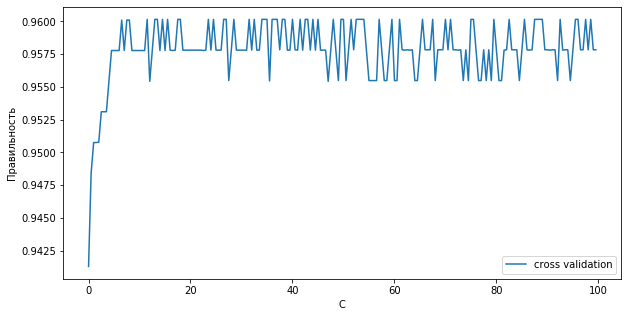

In [52]:
# Подбор параметра С из диапазона от 0.01 до 100 с шагом 0.05
param = np.arange(0.01,100,0.5)
scores = []
for c in param:
    log_reg = LogisticRegression(C = c)
    scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
    scores.append(np.mean(scor))

plt.plot(param, scores,label = 'cross validation')
plt.ylabel("Правильность")
plt.xlabel("C")
plt.legend()
plt.plot()
rcParams['figure.figsize'] = 20, 15

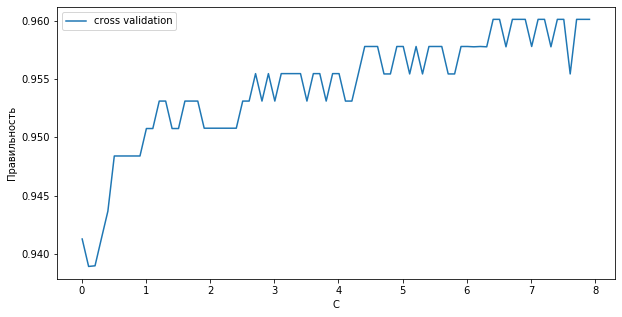

In [55]:
# При С ~ 8 правильность бльше 0.96 не поднимается
# рассмотрим этот участок

param = np.arange(0.01,8,0.1)
scores = []
for c in param:
    log_reg = LogisticRegression(C = c)
    scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
    scores.append(np.mean(scor))

plt.plot(param, scores,label = 'cross validation')
plt.ylabel("Правильность")
plt.xlabel("C")
plt.legend()
plt.plot()
rcParams['figure.figsize'] = 5, 5

Приавильность при С = 6.5: 0.958


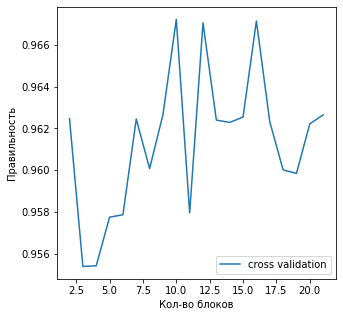

In [87]:
# при C = 6.5 достигается наибольшая точность 
log_reg = LogisticRegression(C = 6.5)
scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
print('Приавильность при С = 6.5: {:.3f}'.format(np.mean(scor)))

# влияние кол-ва блоков в кросс валидации на ззначение правильности
blocks = np.arange(2,22,1)
scores = []
for b in blocks:
    log_reg = LogisticRegression(C = 6.5)
    scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = b)
    scores.append(np.mean(scor))

plt.plot(blocks, scores,label = 'cross validation')
plt.ylabel("Правильность")
plt.xlabel("Кол-во блоков")
plt.legend()
plt.plot()
rcParams['figure.figsize'] = 5, 5

In [89]:
# При параметре C = 6.5 и cv = 10 достигается правильность больше 96%

log_reg = LogisticRegression(C = 6.5)
scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 10)
print(np.mean(scor))

0.967217675499014
